In [1]:
import sys
sys.path.append("..")
import argparse
import os
import numpy as np
import dgl
from dgl import DGLGraph
import dgl.function as fn
from dgl.nn.pytorch import GraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl.data import register_data_args, load_data
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import binary_cross_entropy_with_logits as BCELoss
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import Counter
import pickle
import h5py
import random
#import train
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import glob2
import scanpy as sc #.api
import seaborn as sns

%load_ext autoreload
%autoreload 2

Using backend: pytorch


In [2]:
adata=sc.read_h5ad('D:/COVID5/nCoV-wop4.h5ad')

C:\Users\Wally\anaconda3\lib\site-packages\anndata\compat\__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [3]:
adata

AnnData object with n_obs × n_vars = 63734 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'ID', 'sample', 'sample_new', 'group', 'group1', 'disease', 'nCoV_mean', 'nFeature_RNA_low', 'nFeature_RNA_high', 'before', 'filter', 'integrated_snn_res.1.2', 'seurat_clusters', 'idt', 'hasnCoV', 'cluster', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'integrated_snn_res.1.21'
    var: 'features', 'SCT_features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'SCT'
    obsp: 'distances'

In [38]:
adata.obs['group']

AAACCTGAGACACTAA_1      HC
AAACCTGAGGAGTACC_1      HC
AAACCTGAGGATATAC_1      HC
AAACCTGAGGTCATCT_1      HC
AAACCTGCACGGATAG_1      HC
                      ... 
TTTGGTTTCGCTTGTC_13    S/C
TTTGTCAAGAAACGCC_13    S/C
TTTGTCACAACACCCG_13    S/C
TTTGTCAGTCTGCAAT_13    S/C
TTTGTCAGTGTTGGGA_13    S/C
Name: group, Length: 66452, dtype: object

In [39]:
adata.obs['seurat_clusters']

AAACCTGAGACACTAA_1      3
AAACCTGAGGAGTACC_1      7
AAACCTGAGGATATAC_1      6
AAACCTGAGGTCATCT_1      3
AAACCTGCACGGATAG_1     10
                       ..
TTTGGTTTCGCTTGTC_13     2
TTTGTCAAGAAACGCC_13    14
TTTGTCACAACACCCG_13    21
TTTGTCAGTCTGCAAT_13    23
TTTGTCAGTGTTGGGA_13    21
Name: seurat_clusters, Length: 66452, dtype: int32

In [40]:
adata.obs['seurat_clusters']=adata.obs['seurat_clusters'].astype(str)

C:\Users\Wally\anaconda3\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
C:\Users\Wally\anaconda3\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical
C:\Users\Wally\anaconda3\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always retur

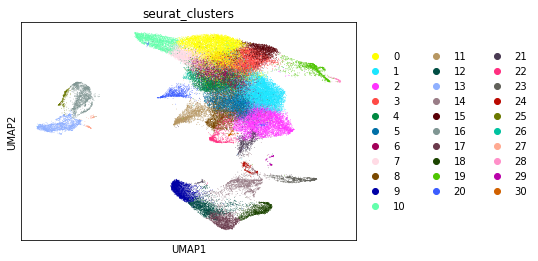

In [41]:
sc.pl.umap(adata, color=['seurat_clusters'])

In [42]:
adata.obs['cluster']

AAACCTGAGACACTAA_1      3
AAACCTGAGGAGTACC_1      3
AAACCTGAGGATATAC_1      3
AAACCTGAGGTCATCT_1      3
AAACCTGCACGGATAG_1      5
                       ..
TTTGGTTTCGCTTGTC_13     1
TTTGTCAAGAAACGCC_13    14
TTTGTCACAACACCCG_13    19
TTTGTCAGTCTGCAAT_13    19
TTTGTCAGTGTTGGGA_13    10
Name: cluster, Length: 66452, dtype: category
Categories (32, object): ['0', '1', '2', '3', ..., '28', '29', '30', '31']

In [43]:
adata.obs['hasnCoV']

AAACCTGAGACACTAA_1     N
AAACCTGAGGAGTACC_1     N
AAACCTGAGGATATAC_1     N
AAACCTGAGGTCATCT_1     N
AAACCTGCACGGATAG_1     N
                      ..
TTTGGTTTCGCTTGTC_13    N
TTTGTCAAGAAACGCC_13    N
TTTGTCACAACACCCG_13    N
TTTGTCAGTCTGCAAT_13    N
TTTGTCAGTGTTGGGA_13    N
Name: hasnCoV, Length: 66452, dtype: category
Categories (2, object): ['N', 'Y']

In [44]:
adata.obs['seurat_clusters']=adata.obs['seurat_clusters'].astype(int)

In [45]:
adata.obs['seurat_clusters'].max()

30

In [46]:
import anndata
adata.obs['barcode']=adata.obs.index
adata.var['genes']=adata.var.index
df_data = anndata.AnnData.to_df(adata)
df_data

,MT1G,CCL18,LYPD2,SCGB1A1,GNLY,KRT17,S100A2,SCGB3A1,CXCL9,C9orf24,...,CSRP2,SLC16A6,CREG1,MYCL,RAET1L,C10orf95,FOXC1,C9orf152,IFT27,OLIG2
AAACCTGAGACACTAA_1,-0.068309,0.388519,0.005378,-0.020056,0.005684,-0.005049,-0.002677,-0.005397,0.689201,0.033989,...,0.092949,0.089784,1.174470,0.104961,0.000027,-0.013569,0.057365,-0.003040,0.053834,0.071814
AAACCTGAGGAGTACC_1,-0.322504,0.771469,0.006790,-0.003910,0.010052,0.004771,-0.000394,0.002851,0.206735,-0.002460,...,-0.021149,0.456537,0.474465,0.036737,0.000049,-0.007829,0.112069,0.008500,0.018811,0.120478
AAACCTGAGGATATAC_1,-0.136147,0.049157,0.001846,-0.001630,0.010205,-0.003316,-0.001103,-0.000803,0.790777,-0.002607,...,0.033623,0.232144,0.483525,-0.050864,0.000094,-0.015977,0.048267,-0.006268,0.006016,0.132368
AAACCTGAGGTCATCT_1,-0.056541,0.608785,-0.005918,0.004375,0.000400,-0.003745,-0.000205,-0.000288,0.918419,0.025468,...,-0.022402,0.155382,0.290822,0.053152,0.000074,-0.100632,-0.003766,0.000143,-0.074845,0.091474
AAACCTGCACGGATAG_1,-0.000328,2.009459,0.002679,0.019074,-0.001255,-0.000133,-0.002099,0.000452,0.257463,0.006846,...,0.015727,0.317383,1.327244,0.032618,0.000011,0.078798,0.068551,-0.002764,-0.099061,0.035494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,-0.036623,0.137411,0.001061,0.000650,-0.009766,0.011652,0.002854,0.098406,0.356432,-0.006312,...,-0.086080,-1.877374,0.494746,-0.093953,0.000000,-0.069750,0.429974,-0.002167,0.259277,-0.160476
TTTGTCAAGAAACGCC_13,-0.074041,0.002215,0.001006,-0.000008,2.796761,0.000313,0.001446,0.000885,-0.007984,-0.009075,...,0.032420,-0.283597,0.047856,-0.000183,0.000496,0.048899,0.001638,0.000508,0.072367,-0.005935
TTTGTCACAACACCCG_13,-0.072937,0.034846,-0.013141,-0.005622,-0.094073,-0.001676,0.004248,0.003439,0.230623,0.101448,...,-0.171519,-0.068010,0.346064,-0.038559,0.000007,-0.109662,0.214361,0.024002,0.126906,0.150848
TTTGTCAGTCTGCAAT_13,-0.012502,0.000361,-0.001173,-0.000850,0.016795,0.001435,-0.000326,0.003691,0.043634,0.004742,...,0.148688,0.045897,0.177031,-0.041531,0.000016,-0.115679,0.068163,-0.000142,0.120661,0.032805


In [47]:
df_data=df_data.T

In [48]:
df_data=pow(df_data,10)

In [49]:
df_data

,AAACCTGAGACACTAA_1,AAACCTGAGGAGTACC_1,AAACCTGAGGATATAC_1,AAACCTGAGGTCATCT_1,AAACCTGCACGGATAG_1,AAACCTGCAGGGAGAG_1,AAACCTGGTCTAAACC_1,AAACCTGGTGCACCAC_1,AAACCTGGTTACGCGC_1,AAACCTGTCCGCATCT_1,...,TTTGGTTCACGAGAGT_13,TTTGGTTCACTATCTT_13,TTTGGTTCATCGGGTC_13,TTTGGTTGTCTCTCTG_13,TTTGGTTTCAAACCAC_13,TTTGGTTTCGCTTGTC_13,TTTGTCAAGAAACGCC_13,TTTGTCACAACACCCG_13,TTTGTCAGTCTGCAAT_13,TTTGTCAGTGTTGGGA_13
MT1G,2.211986e-12,1.217173e-05,2.188191e-09,3.339112e-13,1.461992e-35,1.014085e-23,1.925293e-06,1.344170e-15,1.000861e-10,1.193462e-09,...,8.329768e-08,4.016171e-11,7.542137e-09,6.957895e-09,7.532438e-16,4.340498e-15,4.951627e-12,4.260958e-12,9.327819e-20,1.995796e-06
CCL18,7.836601e-05,7.467664e-02,8.237906e-14,6.992662e-03,1.073474e+03,6.962880e-01,9.792720e+01,1.134621e+02,1.432929e-01,2.376697e+01,...,1.431162e-09,1.266719e-30,1.137900e-07,5.768089e-12,4.739318e-20,2.399983e-09,2.843617e-27,2.639853e-15,3.804905e-35,1.198886e-09
LYPD2,2.025075e-23,2.083928e-22,4.586704e-28,5.269241e-23,1.903293e-26,2.012519e-24,3.177390e-26,1.075538e-32,9.072171e-25,9.816375e-27,...,3.455306e-42,1.416278e-21,2.649663e-26,3.173971e-20,2.717478e+00,1.810444e-30,1.064409e-30,1.535350e-19,4.917076e-30,6.350294e-16
SCGB1A1,1.053260e-17,8.359003e-25,1.325785e-28,2.567509e-24,6.375037e-18,2.424120e-27,4.385788e-22,1.031533e-19,1.105378e-21,7.406612e-24,...,1.971586e-39,2.364697e-27,3.882103e-32,3.814757e-42,3.032630e-08,1.348077e-32,8.918364e-52,3.156565e-23,1.959768e-31,9.531196e-20
GNLY,3.520351e-23,1.052872e-20,1.225483e-20,1.052702e-34,9.663279e-30,6.315077e-19,1.655831e-26,5.199289e-30,1.270473e-29,4.742851e-19,...,3.871708e-17,2.252964e-06,4.169066e-21,2.129608e-24,9.609245e-27,7.889483e-21,2.927881e+04,5.428150e-11,1.785953e-18,2.087935e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C10orf95,2.116288e-19,8.651184e-22,1.084094e-18,1.065002e-10,9.229163e-12,1.909326e-09,3.039726e-13,8.522335e-14,1.895899e-14,1.712617e-08,...,6.596243e-11,5.106263e-19,3.059431e-07,2.998743e-06,7.145206e-08,2.725416e-12,7.816986e-14,2.515051e-10,4.290827e-10,3.138044e-16
FOXC1,3.858845e-13,3.124925e-10,6.863212e-14,5.733671e-25,2.291641e-12,1.963049e-09,2.944827e-15,2.339277e-25,2.405845e-14,4.212937e-17,...,3.580403e-14,6.550026e-31,3.046851e-24,1.055102e-19,1.419984e+03,2.159846e-04,1.389771e-28,2.048589e-07,2.165211e-12,5.754934e-21
C9orf152,6.742374e-26,1.967637e-21,9.360212e-23,3.502523e-39,2.605582e-26,6.415613e-18,3.390858e-21,2.260355e-37,7.512315e-22,2.914850e-28,...,1.265646e-35,1.205234e-25,8.084808e-33,2.359206e-19,4.144238e+00,2.285022e-27,1.134100e-33,6.344506e-17,3.422356e-39,4.841496e-17
IFT27,2.044338e-13,5.547966e-18,6.207459e-23,5.515697e-12,9.099916e-11,1.905521e-12,3.592585e-15,9.133897e-21,7.505232e-17,7.731040e-10,...,9.802220e-10,1.312760e+02,1.019626e-07,2.047671e-10,9.070714e-04,1.372910e-06,3.939445e-12,1.083465e-09,6.541557e-10,4.590698e-08


In [50]:
df_data=df_data/df_data.sum()

In [51]:
df_data.sum()

AAACCTGAGACACTAA_1     1.0
AAACCTGAGGAGTACC_1     1.0
AAACCTGAGGATATAC_1     1.0
AAACCTGAGGTCATCT_1     1.0
AAACCTGCACGGATAG_1     1.0
                      ... 
TTTGGTTTCGCTTGTC_13    1.0
TTTGTCAAGAAACGCC_13    1.0
TTTGTCACAACACCCG_13    1.0
TTTGTCAGTCTGCAAT_13    1.0
TTTGTCAGTGTTGGGA_13    1.0
Length: 66452, dtype: float64

In [52]:
df_data=df_data.T

In [53]:
df_data

,MT1G,CCL18,LYPD2,SCGB1A1,GNLY,KRT17,S100A2,SCGB3A1,CXCL9,C9orf24,...,CSRP2,SLC16A6,CREG1,MYCL,RAET1L,C10orf95,FOXC1,C9orf152,IFT27,OLIG2
AAACCTGAGACACTAA_1,5.055960e-19,1.791220e-11,4.628736e-30,2.407447e-24,8.046504e-30,2.459095e-30,4.321552e-33,4.790749e-30,5.526852e-09,4.703680e-22,...,1.100229e-17,7.780881e-18,1.141410e-06,3.709270e-17,4.144745e-53,4.837221e-26,8.820203e-20,1.541112e-32,4.672765e-20,8.339147e-19
AAACCTGAGGAGTACC_1,1.573089e-13,9.651300e-10,2.693294e-30,1.080328e-32,1.360745e-28,7.902513e-32,1.164316e-42,4.580570e-34,1.843109e-15,1.049467e-34,...,2.314007e-25,5.083477e-12,7.472073e-12,5.786447e-23,9.487724e-52,1.118090e-29,4.038691e-18,2.542999e-29,7.170260e-26,8.326810e-18
AAACCTGAGGATATAC_1,1.900205e-19,7.153724e-24,3.983053e-38,1.151300e-38,1.064198e-30,1.395399e-35,2.322994e-40,9.720404e-42,8.303387e-12,1.258761e-36,...,1.603366e-25,3.947124e-17,6.066011e-14,1.006599e-23,4.484929e-51,9.414176e-29,5.959952e-24,8.128324e-33,5.390502e-33,1.433962e-19
AAACCTGAGGTCATCT_1,4.662735e-21,9.764551e-11,7.357966e-31,3.585269e-32,1.469993e-42,7.569981e-33,1.861414e-45,5.546646e-44,5.962369e-09,1.603017e-24,...,4.446035e-25,1.145571e-16,6.043357e-14,2.513161e-21,6.797790e-50,1.487169e-18,8.006497e-33,4.890922e-47,7.702117e-20,5.727488e-19
AAACCTGCACGGATAG_1,9.356306e-44,6.869907e-06,1.218050e-34,4.079830e-26,6.184204e-38,1.104034e-47,1.060943e-35,2.282762e-42,8.190502e-15,1.447120e-30,...,5.923518e-27,6.637367e-14,1.085597e-07,8.725380e-24,1.386836e-58,5.906383e-20,1.466581e-20,1.667493e-34,5.823670e-19,2.030781e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,2.931892e-25,1.621125e-19,1.222907e-40,9.105905e-43,5.329138e-31,3.117173e-30,2.422925e-36,5.751828e-21,2.235499e-15,6.782798e-33,...,1.508874e-21,3.673807e-08,5.935092e-14,3.619931e-21,0.000000e+00,1.840947e-22,1.458919e-14,1.543472e-37,9.273644e-17,7.650745e-19
TTTGTCAAGAAACGCC_13,2.822979e-22,1.621178e-37,6.068317e-41,5.084461e-62,1.669218e-06,5.103034e-46,2.275063e-39,1.673679e-41,6.001325e-32,2.160602e-31,...,7.312228e-26,1.918594e-16,3.592013e-24,2.378449e-48,5.158556e-44,4.456552e-24,7.923240e-39,6.465630e-44,2.245922e-22,3.089925e-33
TTTGTCACAACACCCG_13,1.053903e-22,6.529396e-26,3.797525e-30,7.807428e-34,1.342595e-21,4.326699e-39,4.735972e-35,5.717063e-36,1.052758e-17,2.855926e-21,...,5.450210e-19,5.236631e-23,6.093343e-16,1.797244e-25,1.332530e-62,6.220712e-21,5.066968e-18,1.569246e-27,2.679835e-20,1.509013e-19
TTTGTCAGTCTGCAAT_13,1.315616e-29,5.366520e-45,6.935149e-40,2.764099e-41,2.518946e-28,5.235194e-39,1.933640e-45,6.610423e-35,3.528840e-24,8.110765e-34,...,7.449042e-19,5.850934e-24,4.264240e-18,2.153164e-24,1.941967e-58,6.051874e-20,3.053861e-22,4.826964e-49,9.226352e-20,2.036114e-25


In [90]:
df_data.to_csv('gene-expression-by-cell-norm1.csv')

In [20]:
b=df_data['nCoV']


In [21]:
b=pd.DataFrame(b)

In [22]:
b

,nCoV
AAACCTGAGACACTAA_1,-0.000121
AAACCTGAGGAGTACC_1,0.001429
AAACCTGAGGATATAC_1,0.000353
AAACCTGAGGTCATCT_1,0.000033
AAACCTGCACGGATAG_1,0.000042
...,...
TTTGGTTTCGCTTGTC_13,-0.000618
TTTGTCAAGAAACGCC_13,-0.000118
TTTGTCACAACACCCG_13,-0.001875
TTTGTCAGTCTGCAAT_13,-0.000757


In [32]:
b['cluster']=adata.obs['seurat_clusters']
type
b

,nCoV,cluster,type
AAACCTGAGACACTAA_1,-0.000121,3,Normal
AAACCTGAGGAGTACC_1,0.001429,7,Normal
AAACCTGAGGATATAC_1,0.000353,6,Normal
AAACCTGAGGTCATCT_1,0.000033,3,Normal
AAACCTGCACGGATAG_1,0.000042,10,Normal
...,...,...,...
TTTGGTTTCGCTTGTC_13,-0.000618,2,Severe
TTTGTCAAGAAACGCC_13,-0.000118,14,Severe
TTTGTCACAACACCCG_13,-0.001875,21,Severe
TTTGTCAGTCTGCAAT_13,-0.000757,23,Severe


In [54]:
adata

AnnData object with n_obs × n_vars = 66452 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'ID', 'sample', 'sample_new', 'group', 'group1', 'disease', 'nCoV_mean', 'nFeature_RNA_low', 'nFeature_RNA_high', 'before', 'filter', 'integrated_snn_res.1.2', 'seurat_clusters', 'idt', 'hasnCoV', 'cluster', 'percent.mt', 'integrated_snn_res.1.21', 'barcode'
    var: 'features', 'genes'
    uns: 'neighbors', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [55]:
adata.obs['hasnCoV'].value_counts()

N    65370
Y     1082
Name: hasnCoV, dtype: int64

In [56]:
adata.obs['nCoV_mean'].value_counts()

0              29255
0.007000048    17340
0.085901131    11872
0.096482152     2904
0.408822508     2071
0.00255102      1718
0.749939188     1292
Name: nCoV_mean, dtype: int64

In [57]:
ar=pd.DataFrame(ar)

In [58]:
ar=adata.obs['group']

In [59]:
ar

AAACCTGAGACACTAA_1      HC
AAACCTGAGGAGTACC_1      HC
AAACCTGAGGATATAC_1      HC
AAACCTGAGGTCATCT_1      HC
AAACCTGCACGGATAG_1      HC
                      ... 
TTTGGTTTCGCTTGTC_13    S/C
TTTGTCAAGAAACGCC_13    S/C
TTTGTCACAACACCCG_13    S/C
TTTGTCAGTCTGCAAT_13    S/C
TTTGTCAGTGTTGGGA_13    S/C
Name: group, Length: 66452, dtype: category
Categories (3, object): ['HC', 'O', 'S/C']

In [29]:
conditions=[
    (ar['group']=='HC'),
    (ar['group']=='O'),
    (ar['group']=='S/C')
]

In [30]:
values=['Normal','Mild','Severe']

In [31]:
ar['type']=np.select(conditions,values)
ar

,group,type
AAACCTGAGACACTAA_1,HC,Normal
AAACCTGAGGAGTACC_1,HC,Normal
AAACCTGAGGATATAC_1,HC,Normal
AAACCTGAGGTCATCT_1,HC,Normal
AAACCTGCACGGATAG_1,HC,Normal
...,...,...
TTTGGTTTCGCTTGTC_13,S/C,Severe
TTTGTCAAGAAACGCC_13,S/C,Severe
TTTGTCACAACACCCG_13,S/C,Severe
TTTGTCAGTCTGCAAT_13,S/C,Severe


In [33]:
b.value_counts()

nCoV       cluster  type  
 0.000000  1        Severe    3371
           2        Severe    2949
           5        Severe    2349
           11       Severe    1569
           0        Severe    1066
                              ... 
-0.000183  6        Normal       1
           12       Mild         1
           3        Normal       1
           12       Normal       1
 0.043970  21       Severe       1
Length: 47534, dtype: int64

In [72]:
b['infected']=0

In [58]:
adata2=sc.read_h5ad('D:/COVID5/nCoV_RNA1.h5ad')

In [59]:
adata2

AnnData object with n_obs × n_vars = 66452 × 23916
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'ID', 'sample', 'sample_new', 'group', 'group1', 'disease', 'nCoV_mean', 'nFeature_RNA_low', 'nFeature_RNA_high', 'before', 'filter', 'integrated_snn_res.1.2', 'seurat_clusters', 'idt', 'hasnCoV', 'cluster'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [60]:
import anndata
adata2.obs['barcode']=adata2.obs.index
adata2.var['genes']=adata2.var.index
df_data2 = anndata.AnnData.to_df(adata2)
df_data2

,AL627309.1,AL669831.5,FAM87B,LINC00115,FAM41C,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,...,IGLV2-5,IGLJ2,IGLJ3,IGLC4,IGLC5,AL022324.3,AL008719.1,AL008718.2,AL023802.1,AC141272.1
AAACCTGAGACACTAA_1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,2.357441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGAGTACC_1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGATATAC_1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,3.457447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGTCATCT_1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,2.597744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGCACGGATAG_1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.858265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,2.298635,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCAAGAAACGCC_13,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.733842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCACAACACCCG_13,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCAGTCTGCAAT_13,0.0,0.0,0.0,0.0,0.0,0.662747,0.385301,0.0,0.000000,1.560344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
df_data2['nCoV'].value_counts()

0.000000    65370
2.382582        3
2.278727        3
2.221042        3
0.985857        2
            ...  
1.498425        1
2.281880        1
1.857599        1
2.940280        1
2.954538        1
Name: nCoV, Length: 1023, dtype: int64

In [71]:
66452-65370

1082

In [62]:
b['nCoV']=df_data2['nCoV']
b

,nCoV,cluster,type,infected,nCoV_mean,clusters
AAACCTGAGACACTAA_1,0.0,3,Normal,0,0.000000,3
AAACCTGAGGAGTACC_1,0.0,7,Normal,0,0.000000,7
AAACCTGAGGATATAC_1,0.0,6,Normal,0,0.000000,6
AAACCTGAGGTCATCT_1,0.0,3,Normal,0,0.000000,3
AAACCTGCACGGATAG_1,0.0,10,Normal,0,0.000000,10
...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,0.0,2,Severe,1,0.096482,2
TTTGTCAAGAAACGCC_13,0.0,14,Severe,1,0.096482,14
TTTGTCACAACACCCG_13,0.0,21,Severe,1,0.096482,21
TTTGTCAGTCTGCAAT_13,0.0,23,Severe,1,0.096482,23


In [63]:
b['nCoV']=b['nCoV'].astype(float)

In [73]:
for x in b.index:
    if b['nCoV'][x]>0:
        b['infected'][x]=1

C:\Users\Wally\AppData\Local\Temp/ipykernel_3056/706452745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['infected'][x]=1


In [74]:
b['infected'].value_counts()

0    65370
1     1082
Name: infected, dtype: int64

In [75]:
b['infected'].value_counts()

0    65370
1     1082
Name: infected, dtype: int64

In [76]:
adata.obs['hasnCoV'].value_counts()

N    65370
Y     1082
Name: hasnCoV, dtype: int64

In [77]:
b['clusters']=adata.obs['seurat_clusters']

In [79]:
b=b.drop(columns=['nCoV','nCoV_mean'])

In [80]:
b

,cluster,type,infected,clusters
AAACCTGAGACACTAA_1,3,Normal,0,3
AAACCTGAGGAGTACC_1,7,Normal,0,7
AAACCTGAGGATATAC_1,6,Normal,0,6
AAACCTGAGGTCATCT_1,3,Normal,0,3
AAACCTGCACGGATAG_1,10,Normal,0,10
...,...,...,...,...
TTTGGTTTCGCTTGTC_13,2,Severe,0,2
TTTGTCAAGAAACGCC_13,14,Severe,0,14
TTTGTCACAACACCCG_13,21,Severe,0,21
TTTGTCAGTCTGCAAT_13,23,Severe,0,23


In [81]:
b.to_csv('infection-cluster-type.csv')

In [60]:
import anndata
adata.obs['barcode']=adata.obs.index
adata.var['genes']=adata.var.index
df_data = anndata.AnnData.to_df(adata)
df_data

,MT1G,CCL18,LYPD2,SCGB1A1,GNLY,KRT17,S100A2,SCGB3A1,CXCL9,C9orf24,...,CSRP2,SLC16A6,CREG1,MYCL,RAET1L,C10orf95,FOXC1,C9orf152,IFT27,OLIG2
AAACCTGAGACACTAA_1,-0.068309,0.388519,0.005378,-0.020056,0.005684,-0.005049,-0.002677,-0.005397,0.689201,0.033989,...,0.092949,0.089784,1.174470,0.104961,0.000027,-0.013569,0.057365,-0.003040,0.053834,0.071814
AAACCTGAGGAGTACC_1,-0.322504,0.771469,0.006790,-0.003910,0.010052,0.004771,-0.000394,0.002851,0.206735,-0.002460,...,-0.021149,0.456537,0.474465,0.036737,0.000049,-0.007829,0.112069,0.008500,0.018811,0.120478
AAACCTGAGGATATAC_1,-0.136147,0.049157,0.001846,-0.001630,0.010205,-0.003316,-0.001103,-0.000803,0.790777,-0.002607,...,0.033623,0.232144,0.483525,-0.050864,0.000094,-0.015977,0.048267,-0.006268,0.006016,0.132368
AAACCTGAGGTCATCT_1,-0.056541,0.608785,-0.005918,0.004375,0.000400,-0.003745,-0.000205,-0.000288,0.918419,0.025468,...,-0.022402,0.155382,0.290822,0.053152,0.000074,-0.100632,-0.003766,0.000143,-0.074845,0.091474
AAACCTGCACGGATAG_1,-0.000328,2.009459,0.002679,0.019074,-0.001255,-0.000133,-0.002099,0.000452,0.257463,0.006846,...,0.015727,0.317383,1.327244,0.032618,0.000011,0.078798,0.068551,-0.002764,-0.099061,0.035494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,-0.036623,0.137411,0.001061,0.000650,-0.009766,0.011652,0.002854,0.098406,0.356432,-0.006312,...,-0.086080,-1.877374,0.494746,-0.093953,0.000000,-0.069750,0.429974,-0.002167,0.259277,-0.160476
TTTGTCAAGAAACGCC_13,-0.074041,0.002215,0.001006,-0.000008,2.796761,0.000313,0.001446,0.000885,-0.007984,-0.009075,...,0.032420,-0.283597,0.047856,-0.000183,0.000496,0.048899,0.001638,0.000508,0.072367,-0.005935
TTTGTCACAACACCCG_13,-0.072937,0.034846,-0.013141,-0.005622,-0.094073,-0.001676,0.004248,0.003439,0.230623,0.101448,...,-0.171519,-0.068010,0.346064,-0.038559,0.000007,-0.109662,0.214361,0.024002,0.126906,0.150848
TTTGTCAGTCTGCAAT_13,-0.012502,0.000361,-0.001173,-0.000850,0.016795,0.001435,-0.000326,0.003691,0.043634,0.004742,...,0.148688,0.045897,0.177031,-0.041531,0.000016,-0.115679,0.068163,-0.000142,0.120661,0.032805


In [61]:
df_data

,MT1G,CCL18,LYPD2,SCGB1A1,GNLY,KRT17,S100A2,SCGB3A1,CXCL9,C9orf24,...,CSRP2,SLC16A6,CREG1,MYCL,RAET1L,C10orf95,FOXC1,C9orf152,IFT27,OLIG2
AAACCTGAGACACTAA_1,-0.068309,0.388519,0.005378,-0.020056,0.005684,-0.005049,-0.002677,-0.005397,0.689201,0.033989,...,0.092949,0.089784,1.174470,0.104961,0.000027,-0.013569,0.057365,-0.003040,0.053834,0.071814
AAACCTGAGGAGTACC_1,-0.322504,0.771469,0.006790,-0.003910,0.010052,0.004771,-0.000394,0.002851,0.206735,-0.002460,...,-0.021149,0.456537,0.474465,0.036737,0.000049,-0.007829,0.112069,0.008500,0.018811,0.120478
AAACCTGAGGATATAC_1,-0.136147,0.049157,0.001846,-0.001630,0.010205,-0.003316,-0.001103,-0.000803,0.790777,-0.002607,...,0.033623,0.232144,0.483525,-0.050864,0.000094,-0.015977,0.048267,-0.006268,0.006016,0.132368
AAACCTGAGGTCATCT_1,-0.056541,0.608785,-0.005918,0.004375,0.000400,-0.003745,-0.000205,-0.000288,0.918419,0.025468,...,-0.022402,0.155382,0.290822,0.053152,0.000074,-0.100632,-0.003766,0.000143,-0.074845,0.091474
AAACCTGCACGGATAG_1,-0.000328,2.009459,0.002679,0.019074,-0.001255,-0.000133,-0.002099,0.000452,0.257463,0.006846,...,0.015727,0.317383,1.327244,0.032618,0.000011,0.078798,0.068551,-0.002764,-0.099061,0.035494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,-0.036623,0.137411,0.001061,0.000650,-0.009766,0.011652,0.002854,0.098406,0.356432,-0.006312,...,-0.086080,-1.877374,0.494746,-0.093953,0.000000,-0.069750,0.429974,-0.002167,0.259277,-0.160476
TTTGTCAAGAAACGCC_13,-0.074041,0.002215,0.001006,-0.000008,2.796761,0.000313,0.001446,0.000885,-0.007984,-0.009075,...,0.032420,-0.283597,0.047856,-0.000183,0.000496,0.048899,0.001638,0.000508,0.072367,-0.005935
TTTGTCACAACACCCG_13,-0.072937,0.034846,-0.013141,-0.005622,-0.094073,-0.001676,0.004248,0.003439,0.230623,0.101448,...,-0.171519,-0.068010,0.346064,-0.038559,0.000007,-0.109662,0.214361,0.024002,0.126906,0.150848
TTTGTCAGTCTGCAAT_13,-0.012502,0.000361,-0.001173,-0.000850,0.016795,0.001435,-0.000326,0.003691,0.043634,0.004742,...,0.148688,0.045897,0.177031,-0.041531,0.000016,-0.115679,0.068163,-0.000142,0.120661,0.032805


In [62]:
df_data=pow(df_data,10)

In [63]:
df_data

,MT1G,CCL18,LYPD2,SCGB1A1,GNLY,KRT17,S100A2,SCGB3A1,CXCL9,C9orf24,...,CSRP2,SLC16A6,CREG1,MYCL,RAET1L,C10orf95,FOXC1,C9orf152,IFT27,OLIG2
AAACCTGAGACACTAA_1,2.211986e-12,7.836601e-05,2.025075e-23,1.053260e-17,3.520351e-23,1.075856e-23,1.890682e-26,2.095956e-23,2.418002e-02,2.057863e-15,...,4.813508e-11,3.404141e-11,4.993678e+00,1.622808e-10,1.813329e-46,2.116288e-19,3.858845e-13,6.742374e-26,2.044338e-13,3.648383e-12
AAACCTGAGGAGTACC_1,1.217173e-05,7.467664e-02,2.083928e-22,8.359003e-25,1.052872e-20,6.114545e-24,9.008863e-35,3.544202e-26,1.426100e-07,8.120222e-27,...,1.790456e-17,3.933325e-04,5.781494e-04,4.477246e-15,7.341098e-44,8.651184e-22,3.124925e-10,1.967637e-21,5.547966e-18,6.442844e-10
AAACCTGAGGATATAC_1,2.188191e-09,8.237906e-14,4.586704e-28,1.325785e-28,1.225483e-20,1.606879e-25,2.675055e-30,1.119358e-31,9.561806e-02,1.449532e-26,...,1.846365e-15,4.545330e-07,6.985345e-04,1.159154e-13,5.164642e-41,1.084094e-18,6.863212e-14,9.360212e-23,6.207459e-23,1.651286e-09
AAACCTGAGGTCATCT_1,3.339112e-13,6.992662e-03,5.269241e-23,2.567509e-24,1.052702e-34,5.421071e-25,1.333010e-37,3.972105e-36,4.269816e-01,1.147964e-16,...,3.183928e-17,8.203748e-09,4.327813e-06,1.799743e-13,4.868084e-42,1.065002e-10,5.733671e-25,3.502523e-39,5.515697e-12,4.101611e-11
AAACCTGCACGGATAG_1,1.461992e-35,1.073474e+03,1.903293e-26,6.375037e-18,9.663279e-30,1.725135e-39,1.657802e-27,3.566984e-34,1.279827e-06,2.261233e-22,...,9.255936e-19,1.037138e-05,1.696326e+01,1.363405e-15,2.167034e-50,9.229163e-12,2.291641e-12,2.605582e-26,9.099916e-11,3.173246e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,4.340498e-15,2.399983e-09,1.810444e-30,1.348077e-32,7.889483e-21,4.614796e-20,3.587002e-26,8.515252e-11,3.309528e-05,1.004154e-22,...,2.233802e-11,5.438861e+02,8.786563e-04,5.359101e-11,0.000000e+00,2.725416e-12,2.159846e-04,2.285022e-27,1.372910e-06,1.132649e-08
TTTGTCAAGAAACGCC_13,4.951627e-12,2.843617e-27,1.064409e-30,8.918364e-52,2.927881e+04,8.950942e-36,3.990559e-29,2.935706e-31,1.052658e-21,3.789790e-21,...,1.282596e-15,3.365296e-06,6.300547e-14,4.171903e-38,9.048330e-34,7.816986e-14,1.389771e-28,1.134100e-33,3.939445e-12,5.419863e-23
TTTGTCACAACACCCG_13,4.260958e-12,2.639853e-15,1.535350e-19,3.156565e-23,5.428150e-11,1.749296e-28,1.914766e-24,2.311424e-25,4.256331e-07,1.154659e-10,...,2.203535e-08,2.117184e-12,2.463555e-05,7.266308e-15,5.387457e-52,2.515051e-10,2.048589e-07,6.344506e-17,1.083465e-09,6.100982e-09
TTTGTCAGTCTGCAAT_13,9.327819e-20,3.804905e-35,4.917076e-30,1.959768e-31,1.785953e-18,3.711794e-29,1.370966e-35,4.686842e-25,2.501975e-14,5.750596e-24,...,5.281430e-09,4.148359e-14,3.023380e-08,1.526610e-14,1.376870e-48,4.290827e-10,2.165211e-12,3.422356e-39,6.541557e-10,1.443621e-15


In [64]:
df_data1=df_data.T
df_data1

,AAACCTGAGACACTAA_1,AAACCTGAGGAGTACC_1,AAACCTGAGGATATAC_1,AAACCTGAGGTCATCT_1,AAACCTGCACGGATAG_1,AAACCTGCAGGGAGAG_1,AAACCTGGTCTAAACC_1,AAACCTGGTGCACCAC_1,AAACCTGGTTACGCGC_1,AAACCTGTCCGCATCT_1,...,TTTGGTTCACGAGAGT_13,TTTGGTTCACTATCTT_13,TTTGGTTCATCGGGTC_13,TTTGGTTGTCTCTCTG_13,TTTGGTTTCAAACCAC_13,TTTGGTTTCGCTTGTC_13,TTTGTCAAGAAACGCC_13,TTTGTCACAACACCCG_13,TTTGTCAGTCTGCAAT_13,TTTGTCAGTGTTGGGA_13
MT1G,2.211986e-12,1.217173e-05,2.188191e-09,3.339112e-13,1.461992e-35,1.014085e-23,1.925293e-06,1.344170e-15,1.000861e-10,1.193462e-09,...,8.329768e-08,4.016171e-11,7.542137e-09,6.957895e-09,7.532438e-16,4.340498e-15,4.951627e-12,4.260958e-12,9.327819e-20,1.995796e-06
CCL18,7.836601e-05,7.467664e-02,8.237906e-14,6.992662e-03,1.073474e+03,6.962880e-01,9.792720e+01,1.134621e+02,1.432929e-01,2.376697e+01,...,1.431162e-09,1.266719e-30,1.137900e-07,5.768089e-12,4.739318e-20,2.399983e-09,2.843617e-27,2.639853e-15,3.804905e-35,1.198886e-09
LYPD2,2.025075e-23,2.083928e-22,4.586704e-28,5.269241e-23,1.903293e-26,2.012519e-24,3.177390e-26,1.075538e-32,9.072171e-25,9.816375e-27,...,3.455306e-42,1.416278e-21,2.649663e-26,3.173971e-20,2.717478e+00,1.810444e-30,1.064409e-30,1.535350e-19,4.917076e-30,6.350294e-16
SCGB1A1,1.053260e-17,8.359003e-25,1.325785e-28,2.567509e-24,6.375037e-18,2.424120e-27,4.385788e-22,1.031533e-19,1.105378e-21,7.406612e-24,...,1.971586e-39,2.364697e-27,3.882103e-32,3.814757e-42,3.032630e-08,1.348077e-32,8.918364e-52,3.156565e-23,1.959768e-31,9.531196e-20
GNLY,3.520351e-23,1.052872e-20,1.225483e-20,1.052702e-34,9.663279e-30,6.315077e-19,1.655831e-26,5.199289e-30,1.270473e-29,4.742851e-19,...,3.871708e-17,2.252964e-06,4.169066e-21,2.129608e-24,9.609245e-27,7.889483e-21,2.927881e+04,5.428150e-11,1.785953e-18,2.087935e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C10orf95,2.116288e-19,8.651184e-22,1.084094e-18,1.065002e-10,9.229163e-12,1.909326e-09,3.039726e-13,8.522335e-14,1.895899e-14,1.712617e-08,...,6.596243e-11,5.106263e-19,3.059431e-07,2.998743e-06,7.145206e-08,2.725416e-12,7.816986e-14,2.515051e-10,4.290827e-10,3.138044e-16
FOXC1,3.858845e-13,3.124925e-10,6.863212e-14,5.733671e-25,2.291641e-12,1.963049e-09,2.944827e-15,2.339277e-25,2.405845e-14,4.212937e-17,...,3.580403e-14,6.550026e-31,3.046851e-24,1.055102e-19,1.419984e+03,2.159846e-04,1.389771e-28,2.048589e-07,2.165211e-12,5.754934e-21
C9orf152,6.742374e-26,1.967637e-21,9.360212e-23,3.502523e-39,2.605582e-26,6.415613e-18,3.390858e-21,2.260355e-37,7.512315e-22,2.914850e-28,...,1.265646e-35,1.205234e-25,8.084808e-33,2.359206e-19,4.144238e+00,2.285022e-27,1.134100e-33,6.344506e-17,3.422356e-39,4.841496e-17
IFT27,2.044338e-13,5.547966e-18,6.207459e-23,5.515697e-12,9.099916e-11,1.905521e-12,3.592585e-15,9.133897e-21,7.505232e-17,7.731040e-10,...,9.802220e-10,1.312760e+02,1.019626e-07,2.047671e-10,9.070714e-04,1.372910e-06,3.939445e-12,1.083465e-09,6.541557e-10,4.590698e-08


In [65]:
df_data1=df_data1.T
df_data1

,MT1G,CCL18,LYPD2,SCGB1A1,GNLY,KRT17,S100A2,SCGB3A1,CXCL9,C9orf24,...,CSRP2,SLC16A6,CREG1,MYCL,RAET1L,C10orf95,FOXC1,C9orf152,IFT27,OLIG2
AAACCTGAGACACTAA_1,2.211986e-12,7.836601e-05,2.025075e-23,1.053260e-17,3.520351e-23,1.075856e-23,1.890682e-26,2.095956e-23,2.418002e-02,2.057863e-15,...,4.813508e-11,3.404141e-11,4.993678e+00,1.622808e-10,1.813329e-46,2.116288e-19,3.858845e-13,6.742374e-26,2.044338e-13,3.648383e-12
AAACCTGAGGAGTACC_1,1.217173e-05,7.467664e-02,2.083928e-22,8.359003e-25,1.052872e-20,6.114545e-24,9.008863e-35,3.544202e-26,1.426100e-07,8.120222e-27,...,1.790456e-17,3.933325e-04,5.781494e-04,4.477246e-15,7.341098e-44,8.651184e-22,3.124925e-10,1.967637e-21,5.547966e-18,6.442844e-10
AAACCTGAGGATATAC_1,2.188191e-09,8.237906e-14,4.586704e-28,1.325785e-28,1.225483e-20,1.606879e-25,2.675055e-30,1.119358e-31,9.561806e-02,1.449532e-26,...,1.846365e-15,4.545330e-07,6.985345e-04,1.159154e-13,5.164642e-41,1.084094e-18,6.863212e-14,9.360212e-23,6.207459e-23,1.651286e-09
AAACCTGAGGTCATCT_1,3.339112e-13,6.992662e-03,5.269241e-23,2.567509e-24,1.052702e-34,5.421071e-25,1.333010e-37,3.972105e-36,4.269816e-01,1.147964e-16,...,3.183928e-17,8.203748e-09,4.327813e-06,1.799743e-13,4.868084e-42,1.065002e-10,5.733671e-25,3.502523e-39,5.515697e-12,4.101611e-11
AAACCTGCACGGATAG_1,1.461992e-35,1.073474e+03,1.903293e-26,6.375037e-18,9.663279e-30,1.725135e-39,1.657802e-27,3.566984e-34,1.279827e-06,2.261233e-22,...,9.255936e-19,1.037138e-05,1.696326e+01,1.363405e-15,2.167034e-50,9.229163e-12,2.291641e-12,2.605582e-26,9.099916e-11,3.173246e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,4.340498e-15,2.399983e-09,1.810444e-30,1.348077e-32,7.889483e-21,4.614796e-20,3.587002e-26,8.515252e-11,3.309528e-05,1.004154e-22,...,2.233802e-11,5.438861e+02,8.786563e-04,5.359101e-11,0.000000e+00,2.725416e-12,2.159846e-04,2.285022e-27,1.372910e-06,1.132649e-08
TTTGTCAAGAAACGCC_13,4.951627e-12,2.843617e-27,1.064409e-30,8.918364e-52,2.927881e+04,8.950942e-36,3.990559e-29,2.935706e-31,1.052658e-21,3.789790e-21,...,1.282596e-15,3.365296e-06,6.300547e-14,4.171903e-38,9.048330e-34,7.816986e-14,1.389771e-28,1.134100e-33,3.939445e-12,5.419863e-23
TTTGTCACAACACCCG_13,4.260958e-12,2.639853e-15,1.535350e-19,3.156565e-23,5.428150e-11,1.749296e-28,1.914766e-24,2.311424e-25,4.256331e-07,1.154659e-10,...,2.203535e-08,2.117184e-12,2.463555e-05,7.266308e-15,5.387457e-52,2.515051e-10,2.048589e-07,6.344506e-17,1.083465e-09,6.100982e-09
TTTGTCAGTCTGCAAT_13,9.327819e-20,3.804905e-35,4.917076e-30,1.959768e-31,1.785953e-18,3.711794e-29,1.370966e-35,4.686842e-25,2.501975e-14,5.750596e-24,...,5.281430e-09,4.148359e-14,3.023380e-08,1.526610e-14,1.376870e-48,4.290827e-10,2.165211e-12,3.422356e-39,6.541557e-10,1.443621e-15


In [69]:
df_data1['seurat_clusters']=adata.obs['seurat_clusters']

In [70]:
df_data1['seurat_clusters'].value_counts()

0     7148
1     7130
2     6124
3     4985
4     4316
5     4107
6     3468
7     3021
8     2490
9     2438
10    2374
11    1906
12    1761
13    1752
14    1651
15    1625
16    1588
17    1568
18    1204
19    1150
20     956
21     866
22     821
23     755
24     302
25     252
26     245
27     133
28     127
29     105
30      84
Name: seurat_clusters, dtype: int64

In [71]:
df_data1['seurat_clusters'].max()

30

In [72]:
av=pd.DataFrame(index=range(0,31), columns=df_data1.columns)

In [73]:
c=pd.DataFrame()

In [74]:
for x in range(0,31):
    a=df_data1[df_data1['seurat_clusters']==x]
    b=a.mean()
    b=pd.DataFrame(b)
    b=b.T
    b['index']=x
    b=b.set_index(b['index'])
    c=c.append(b)

In [75]:
c

,MT1G,CCL18,LYPD2,SCGB1A1,GNLY,KRT17,S100A2,SCGB3A1,CXCL9,C9orf24,...,CREG1,MYCL,RAET1L,C10orf95,FOXC1,C9orf152,IFT27,OLIG2,seurat_clusters,index
index,,,,,,,,,,,,,,,,,,,,,
0,1.629134e+03,5.143645e+07,2.000658e-03,5.375067e-04,3.720161e-03,2.146571e-06,1.463920e-08,7.252654e-01,5.649137e+05,1.734385e+00,...,2.076515e+06,5.407953e+06,1.989982e-14,6.056293e+06,3.833051e+06,4.906590e-09,4.449047e+06,1.089958e+05,0.0,0
1,4.730063e+02,9.294119e+05,9.802424e-03,1.402525e+06,2.135053e+03,4.416214e-05,1.917546e-05,2.805049e+06,6.232848e+06,6.062435e+00,...,1.740666e+06,1.314544e+07,2.107895e-08,9.514573e+06,1.886572e+07,6.889447e-04,2.745440e+06,3.250478e+07,1.0,1
2,4.958287e+05,1.992093e+00,1.293355e-02,9.968447e-04,3.041723e+00,8.337471e-05,3.584666e-07,2.032301e-01,4.614056e+07,2.127265e+03,...,7.025706e+05,1.170166e+07,3.265839e+06,1.498887e+07,1.949108e+07,6.948015e-06,2.858433e+06,1.052842e+08,2.0,2
3,2.322956e+02,1.700368e+04,8.578750e-07,2.803429e+01,1.913181e-01,1.452959e-11,6.973316e-10,1.521546e+01,8.496813e+06,7.803765e-01,...,3.952223e+05,6.310186e+08,1.279459e-11,7.461129e+06,6.119353e+06,8.771676e-06,6.964260e+06,7.184431e+01,3.0,3
4,1.032893e+04,2.866121e+03,6.363213e+03,4.127135e+05,1.372927e+01,5.212964e-03,1.616618e-07,2.058786e-01,2.764144e+04,4.007888e-01,...,3.328753e+05,9.018750e+05,6.454473e-10,4.579783e+06,2.365558e+06,1.248848e-10,2.869324e+06,3.245196e+06,4.0,4
5,2.456240e+06,5.361113e+01,1.202541e+01,4.065445e+03,5.006490e-03,5.535771e-06,1.333340e-07,4.020816e+01,1.145470e+08,4.587437e+01,...,3.966865e+05,1.002245e+07,1.390217e-05,7.539425e+06,1.807798e+07,1.089570e-04,7.315239e+06,2.755213e+07,5.0,5
6,1.114201e+04,1.129937e+05,1.458382e-08,2.597153e-06,1.239424e+01,5.673833e-12,5.806357e-08,8.728309e-08,2.980683e+06,5.342235e-01,...,1.100785e+04,3.505874e+06,1.869944e-16,3.473304e+05,3.599008e+06,5.094466e+02,2.587095e+05,7.187504e+04,6.0,6
7,3.537474e+03,4.623871e+06,1.176740e-07,4.687641e-01,9.996038e-01,7.840593e-11,4.869014e-10,8.879856e+03,2.042821e+01,5.033685e+01,...,7.261673e+05,6.149259e-03,1.333743e-10,2.003024e+04,1.254840e+05,6.156741e+03,9.583088e+06,5.164395e+01,7.0,7
8,1.754506e+04,1.570249e+06,8.349936e-05,2.094849e-02,3.226330e-02,2.414708e-05,5.000633e-07,2.502163e-04,3.621546e+07,5.819934e+00,...,5.515134e+05,7.948262e+06,9.005822e-04,6.104312e+04,1.205524e+07,4.566865e+05,1.258251e+06,9.643031e+07,8.0,8


In [76]:
c=c.T

In [77]:
c

index,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
MT1G,1.629134e+03,4.730063e+02,4.958287e+05,2.322956e+02,1.032893e+04,2.456240e+06,1.114201e+04,3.537474e+03,1.754506e+04,4.102286e+06,...,7.279175e+01,5.570558e+02,2.666843e+06,2.362740e+04,2.622787e+01,9.285166e-01,1.503777e+08,1.055364e-08,1.365324e-02,1.917239e+10
CCL18,5.143645e+07,9.294119e+05,1.992093e+00,1.700368e+04,2.866121e+03,5.361113e+01,1.129937e+05,4.623871e+06,1.570249e+06,6.524368e-01,...,1.307958e+03,3.146823e+00,1.640139e+01,1.514731e+07,1.561610e-05,2.840489e+02,3.970533e-02,2.647858e-02,8.175678e-05,6.881714e-02
LYPD2,2.000658e-03,9.802424e-03,1.293355e-02,8.578750e-07,6.363213e+03,1.202541e+01,1.458382e-08,1.176740e-07,8.349936e-05,5.598184e-02,...,7.613027e-04,7.473939e-02,2.201976e-03,1.294083e-06,1.730471e+01,1.776448e-06,3.357856e+00,3.041411e-25,3.585991e-09,2.224503e-13
SCGB1A1,5.375067e-04,1.402525e+06,9.968447e-04,2.803429e+01,4.127135e+05,4.065445e+03,2.597153e-06,4.687641e-01,2.094849e-02,4.606459e+02,...,3.599896e-10,4.010256e-12,1.681923e-12,4.939650e+01,6.346956e+06,4.081633e+07,1.139211e+11,2.702080e+01,1.776296e-04,1.755566e-09
GNLY,3.720161e-03,2.135053e+03,3.041723e+00,1.913181e-01,1.372927e+01,5.006490e-03,1.239424e+01,9.996038e-01,3.226330e-02,6.189906e+03,...,4.206215e+06,8.028808e-05,1.616494e+01,6.550268e-01,6.048379e-10,1.215608e-09,2.661594e-03,5.110760e-13,3.342601e-06,2.932632e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9orf152,4.906590e-09,6.889447e-04,6.948015e-06,8.771676e-06,1.248848e-10,1.089570e-04,5.094466e+02,6.156741e+03,4.566865e+05,2.491697e-07,...,7.175864e-05,5.934287e-15,6.281508e-17,3.682499e-04,2.381010e+08,3.036130e+00,3.726511e+07,3.382881e-18,2.275640e-09,4.841006e-12
IFT27,4.449047e+06,2.745440e+06,2.858433e+06,6.964260e+06,2.869324e+06,7.315239e+06,2.587095e+05,9.583088e+06,1.258251e+06,1.853179e+07,...,1.091869e+07,1.966890e+06,7.897113e+06,7.778690e+06,1.505529e+09,1.083097e+06,1.239316e+08,1.402599e+06,1.603379e+06,1.330403e+07
OLIG2,1.089958e+05,3.250478e+07,1.052842e+08,7.184431e+01,3.245196e+06,2.755213e+07,7.187504e+04,5.164395e+01,9.643031e+07,4.107287e+06,...,5.543138e+05,2.404363e+08,9.599356e+02,2.261578e-05,2.902747e-10,9.769598e-04,1.852920e-04,1.486352e-08,2.550698e-03,2.326336e+07
seurat_clusters,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,2.100000e+01,2.200000e+01,2.300000e+01,2.400000e+01,2.500000e+01,2.600000e+01,2.700000e+01,2.800000e+01,2.900000e+01,3.000000e+01


In [78]:
c=c/c.sum()

In [79]:
c.sum()

index
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
dtype: float64

In [81]:
c=c.T
c

index,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
MT1G,3.243685e-08,4.659986e-08,2.093012e-06,3.525268e-08,2.626106e-07,1.228997e-04,9.975798e-08,1.047083e-07,2.220786e-08,6.007000e-05,...,2.593663e-09,1.005032e-08,6.510670e-06,2.092191e-07,2.191385e-11,6.452417e-11,5.058561e-04,1.150877e-21,4.304072e-19,5.992230e-04
CCL18,1.024125e-03,9.156424e-05,8.409105e-12,2.580442e-06,7.287047e-08,2.682470e-09,1.011669e-06,1.368654e-04,1.987562e-06,9.553669e-12,...,4.660422e-08,5.677454e-11,4.004137e-11,1.341285e-04,1.304753e-17,1.973904e-08,1.335649e-13,2.887494e-15,2.577315e-21,2.150843e-15
LYPD2,3.983407e-14,9.657199e-13,5.459563e-14,1.301893e-16,1.617832e-07,6.016996e-10,1.305737e-19,3.483118e-18,1.056903e-16,8.197452e-13,...,2.712619e-14,1.348438e-12,5.375772e-15,1.145902e-17,1.445839e-11,1.234483e-16,1.129550e-11,3.316665e-38,1.130454e-25,6.952568e-27
SCGB1A1,1.070202e-14,1.381746e-04,4.207921e-15,4.254424e-09,1.049315e-05,2.034174e-07,2.325315e-17,1.387529e-11,2.651580e-14,6.745264e-09,...,1.282689e-20,7.235248e-23,4.106146e-24,4.374028e-10,5.302994e-06,2.836395e-03,3.832197e-01,2.946624e-12,5.599627e-21,5.486929e-23
GNLY,7.407020e-14,2.103422e-07,1.283984e-11,2.903403e-11,3.490636e-10,2.505032e-13,1.109696e-10,2.958801e-11,4.083766e-14,9.063914e-08,...,1.498728e-04,1.448546e-15,3.946410e-11,5.800220e-12,5.053527e-22,8.447464e-20,8.953345e-15,5.573294e-26,1.053727e-22,9.165786e-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9orf152,9.769257e-20,6.787378e-14,2.932924e-17,1.331171e-15,3.175167e-21,5.451739e-15,4.561239e-09,1.822379e-07,5.780564e-07,3.648606e-18,...,2.556852e-15,1.070656e-25,1.533530e-28,3.260829e-15,1.989376e-04,2.109858e-10,1.253563e-04,3.689039e-31,7.173766e-26,1.513031e-25
IFT27,8.858268e-05,2.704766e-04,1.206613e-05,1.056881e-03,7.295190e-05,3.660230e-04,2.316310e-06,2.836569e-04,1.592646e-06,2.713621e-04,...,3.890468e-04,3.548636e-05,1.927953e-05,6.887980e-05,1.257896e-03,7.526621e-05,4.168940e-04,1.529537e-07,5.054519e-11,4.158103e-07
OLIG2,2.170159e-06,3.202321e-03,4.444300e-04,1.090294e-08,8.250837e-05,1.378590e-03,6.435204e-07,1.528648e-09,1.220578e-04,6.014323e-05,...,1.975091e-05,4.337919e-03,2.343529e-09,2.002613e-16,2.425297e-22,6.789057e-14,6.233046e-16,1.620870e-21,8.040865e-20,7.270841e-07
seurat_clusters,0.000000e+00,9.851847e-11,8.442481e-12,4.552736e-10,1.016991e-10,2.501785e-10,5.371993e-11,2.071982e-10,1.012610e-11,1.317875e-10,...,7.482568e-10,3.969210e-10,5.615081e-11,2.125185e-10,2.088794e-11,1.806784e-09,9.082541e-11,3.053406e-12,9.142010e-16,9.376341e-13


In [539]:
c.to_csv('weights-average.csv')

In [263]:
c=c.drop(columns=['seurat_clusters','index'])

In [264]:
c

,MT1G,CCL18,LYPD2,SCGB1A1,GNLY,KRT17,S100A2,SCGB3A1,CXCL9,C9orf24,...,CSRP2,SLC16A6,CREG1,MYCL,RAET1L,C10orf95,FOXC1,C9orf152,IFT27,OLIG2
index,,,,,,,,,,,,,,,,,,,,,
0,8.782210e-04,1.033001e-01,4.245451e-12,2.892789e-10,8.366546e-08,1.269875e-11,1.674092e-15,3.009571e-08,2.200714e-02,2.502524e-09,...,1.840155e-02,2.418109e-02,5.860779e-03,1.513931e-02,2.439178e-21,1.505659e-02,1.721767e-02,9.289407e-13,5.219418e-03,2.970387e-03
1,9.738797e-05,1.179719e-02,1.224926e-11,9.850380e-04,9.820084e-04,6.876468e-14,2.593962e-14,1.298353e-03,3.889549e-02,1.955293e-08,...,2.788905e-02,3.813440e-02,9.907290e-03,3.233512e-02,1.338879e-16,1.844494e-02,3.821606e-02,8.212451e-11,6.504246e-03,3.545360e-02
2,3.216373e-03,7.016478e-07,1.164819e-11,2.359722e-11,1.679032e-08,9.627315e-13,2.657540e-16,1.947627e-10,6.407455e-02,4.465386e-08,...,2.382530e-02,4.426203e-02,7.461805e-04,2.819602e-02,1.610989e-02,2.692113e-02,2.583615e-02,2.497866e-13,4.134604e-03,7.197840e-02
3,7.665710e-06,1.249264e-02,5.670625e-14,1.711261e-03,7.987432e-08,2.019913e-16,3.525913e-15,9.287776e-04,3.884221e-02,5.689669e-09,...,1.423649e-02,6.196287e-03,4.847409e-04,2.294884e-02,4.174822e-20,2.146357e-02,1.700920e-02,5.350384e-10,4.563867e-03,1.436595e-05
4,1.221250e-02,5.642591e-04,4.215093e-06,1.447328e-04,3.472662e-07,1.133340e-11,3.996317e-16,1.105674e-09,1.553233e-02,1.244645e-08,...,9.520786e-03,2.354782e-02,8.156015e-03,2.071928e-02,9.195500e-18,2.393301e-02,7.556453e-03,1.205879e-15,5.472169e-03,1.732973e-02
5,5.881313e-04,1.303354e-04,8.280596e-08,1.413942e-06,3.245168e-10,6.560590e-15,1.373589e-16,9.720045e-05,1.206648e-01,3.550682e-08,...,2.833648e-02,3.702741e-02,2.390298e-03,2.824806e-02,2.770162e-14,1.968940e-02,2.485021e-02,1.300873e-10,5.218852e-03,4.322462e-02
6,2.336744e-04,2.233008e-02,3.502789e-15,1.926626e-15,1.520439e-08,8.868295e-17,1.939351e-15,3.907614e-18,1.356777e-02,2.088109e-09,...,1.591185e-02,1.482780e-02,1.747614e-04,6.145667e-03,3.239635e-22,1.079954e-02,1.682782e-02,7.502330e-03,2.500322e-03,6.874326e-03
7,4.543648e-04,4.647825e-02,4.581522e-14,2.645908e-09,8.579493e-07,2.438504e-17,1.941789e-16,4.826991e-05,4.569668e-04,8.388161e-10,...,6.766327e-03,2.194142e-03,4.103833e-04,3.131985e-11,3.824595e-16,1.688284e-03,1.355525e-02,8.795080e-04,5.311962e-03,4.869515e-04
8,1.541393e-03,4.438110e-03,2.253391e-13,2.565827e-09,5.581562e-09,1.191344e-14,9.934631e-16,5.124322e-13,4.978441e-02,1.355891e-08,...,2.248657e-02,3.476188e-02,5.943990e-04,6.954185e-03,1.552805e-11,7.029909e-04,1.234196e-02,1.952427e-02,3.278153e-03,5.131396e-02


In [265]:
numpy_array = c .to_numpy()

In [368]:
len(numpy_array)

31

In [370]:
df=numpy_array

In [371]:
df

array([[8.78221049e-04, 1.03300096e-01, 4.24545090e-12, ...,
        9.28940694e-13, 5.21941822e-03, 2.97038652e-03],
       [9.73879654e-05, 1.17971886e-02, 1.22492630e-11, ...,
        8.21245144e-11, 6.50424571e-03, 3.54535981e-02],
       [3.21637282e-03, 7.01647849e-07, 1.16481887e-11, ...,
        2.49786575e-13, 4.13460354e-03, 7.19784046e-02],
       ...,
       [1.58123234e-18, 2.07825887e-12, 7.63935019e-35, ...,
        2.72069374e-28, 1.10586172e-04, 3.73929433e-18],
       [6.26465019e-13, 8.63573000e-15, 3.28665444e-19, ...,
        2.11184274e-22, 1.80129229e-09, 3.04189710e-14],
       [1.37664907e-01, 2.77851601e-10, 7.03855917e-22, ...,
        1.80371738e-20, 1.08333661e-02, 5.70408474e-05]])

In [372]:
df.size

62000

In [373]:
pca_dim=31

In [374]:
pca = PCA(n_components=pca_dim).fit_transform(df.T)

In [375]:
pca

array([[ 1.64938738e-02,  5.24202861e-02, -1.54920268e-02, ...,
        -3.53224243e-03,  1.65868490e-03, -3.29983904e-04],
       [ 8.98873088e-02, -5.46336577e-02, -8.92650534e-03, ...,
         7.16098933e-03,  1.08497194e-04, -1.42996357e-03],
       [-2.90885439e-02, -1.20989289e-02, -1.82742802e-02, ...,
        -5.09070070e-03, -5.94947419e-04,  2.53776702e-04],
       ...,
       [-2.23793273e-02, -9.49157676e-03, -1.21684142e-02, ...,
         1.93419041e-03, -1.64263582e-03, -1.44542002e-04],
       [-1.37346886e-02, -5.73706694e-03, -4.18029147e-03, ...,
        -1.08665284e-04,  6.91469299e-03,  9.60971158e-04],
       [ 2.85453504e-02,  7.90852902e-02, -7.51853840e-03, ...,
         4.36793617e-04,  4.59101418e-05, -1.87495861e-04]])

In [376]:
len(pca)

2000

In [377]:
pca.shape

(2000, 31)

In [378]:
df

array([[8.78221049e-04, 1.03300096e-01, 4.24545090e-12, ...,
        9.28940694e-13, 5.21941822e-03, 2.97038652e-03],
       [9.73879654e-05, 1.17971886e-02, 1.22492630e-11, ...,
        8.21245144e-11, 6.50424571e-03, 3.54535981e-02],
       [3.21637282e-03, 7.01647849e-07, 1.16481887e-11, ...,
        2.49786575e-13, 4.13460354e-03, 7.19784046e-02],
       ...,
       [1.58123234e-18, 2.07825887e-12, 7.63935019e-35, ...,
        2.72069374e-28, 1.10586172e-04, 3.73929433e-18],
       [6.26465019e-13, 8.63573000e-15, 3.28665444e-19, ...,
        2.11184274e-22, 1.80129229e-09, 3.04189710e-14],
       [1.37664907e-01, 2.77851601e-10, 7.03855917e-22, ...,
        1.80371738e-20, 1.08333661e-02, 5.70408474e-05]])

In [394]:
len(df)

31

In [395]:
df.shape

(31, 2000)

In [379]:
# edges = np.log1p(df)
edges = df
print(edges)
edges = edges / (np.sum(edges, axis=1, keepdims=True) + 1e-6)
print(edges.round(2))

[[8.78221049e-04 1.03300096e-01 4.24545090e-12 ... 9.28940694e-13
  5.21941822e-03 2.97038652e-03]
 [9.73879654e-05 1.17971886e-02 1.22492630e-11 ... 8.21245144e-11
  6.50424571e-03 3.54535981e-02]
 [3.21637282e-03 7.01647849e-07 1.16481887e-11 ... 2.49786575e-13
  4.13460354e-03 7.19784046e-02]
 ...
 [1.58123234e-18 2.07825887e-12 7.63935019e-35 ... 2.72069374e-28
  1.10586172e-04 3.73929433e-18]
 [6.26465019e-13 8.63573000e-15 3.28665444e-19 ... 2.11184274e-22
  1.80129229e-09 3.04189710e-14]
 [1.37664907e-01 2.77851601e-10 7.03855917e-22 ... 1.80371738e-20
  1.08333661e-02 5.70408474e-05]]
[[0.   0.01 0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.02 0.   0.   ... 0.   0.   0.  ]]


In [396]:
edges.shape

(31, 2000)

In [397]:
node_features = "none"
normalize_weights = "none"

In [398]:
graph = make_graph(df,None,
                         dense_dim=pca_dim,
                         node_features=node_features,    normalize_weights=normalize_weights,
                         edge_norm=True)

C:\Users\Wally\anaconda3\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [399]:
graph

Graph(num_nodes=2031, num_edges=63898,
      ndata_schemes={'id': Scheme(shape=(1,), dtype=torch.int32), 'features': Scheme(shape=(31,), dtype=torch.float32), 'order': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})

In [405]:
graph.edges()

(tensor([1803,  590,  160,  ..., 2028, 2029, 2030]),
 tensor([2028, 2029, 2030,  ..., 2028, 2029, 2030]))

In [403]:
len(graph.edges()[1])

63898

In [390]:
graph.edata["weight"]

tensor([[195.9499],
        [143.6825],
        [ 79.7598],
        ...,
        [  1.0000],
        [  1.0000],
        [  1.0000]])

In [391]:
len(graph.edata["weight"])

63898

In [311]:
graph.ndata

{'id': tensor([[ 0],
        [ 1],
        [ 2],
        ...,
        [-1],
        [-1],
        [-1]], dtype=torch.int32), 'features': tensor([[ 1.6494e-02,  5.2420e-02, -1.5492e-02,  ..., -3.5322e-03,
          1.6587e-03, -3.2998e-04],
        [ 8.9887e-02, -5.4634e-02, -8.9265e-03,  ...,  7.1610e-03,
          1.0850e-04, -1.4300e-03],
        [-2.9089e-02, -1.2099e-02, -1.8274e-02,  ..., -5.0907e-03,
         -5.9495e-04,  2.5378e-04],
        ...,
        [ 4.9396e-03,  1.6513e-02, -7.6819e-04,  ...,  1.1577e-03,
         -9.6649e-05, -1.1591e-04],
        [-3.7646e-03, -2.4646e-02,  1.2199e-02,  ...,  1.0075e-03,
          4.4330e-04, -2.2266e-04],
        [ 1.8382e-01,  2.7763e-01, -7.7293e-03,  ...,  4.1958e-04,
          1.0747e-04, -1.5710e-04]]), 'order': tensor([-1, -1, -1,  ..., 28, 29, 30]), 'label': tensor([-1., -1., -1.,  ..., nan, nan, nan])}

In [312]:
pca = graph.ndata["features"].numpy().round(2)

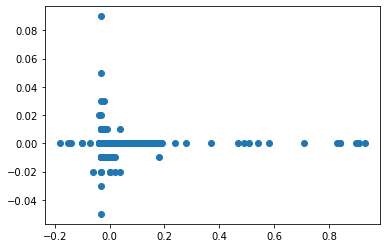

In [313]:
plt.scatter(pca[:,0],pca[:, 30])

Gene 1 [0.02, 0.05]
Gene 2 [0.09, -0.05]
Gene 3 [-0.03, -0.01]
Gene 4 [-0.03, -0.02]
Cell 1 [-0.03, -0.01]
Cell 2 [-0.03, -0.01]
Cell 3 [-0.03, -0.01]
Cell 4 [-0.03, -0.01]
Cell 5 [0.08, 0.12]
Cell 6 [-0.03, -0.01]
Cell 7 [-0.03, -0.01]
Cell 8 [-0.03, -0.01]
Cell 9 [-0.03, -0.01]
Cell 10 [-0.03, -0.01]
Cell 11 [-0.03, -0.01]
Cell 12 [-0.00, 0.03]
Cell 13 [-0.03, -0.01]
Cell 14 [-0.03, -0.01]
Cell 15 [-0.03, -0.01]
Cell 16 [-0.03, -0.01]
Cell 17 [0.08, 0.05]
Cell 18 [-0.02, 0.01]
Cell 19 [-0.03, -0.01]
Cell 20 [-0.03, -0.01]
Cell 21 [0.17, -0.09]
Cell 22 [0.03, 0.05]
Cell 23 [-0.03, -0.01]
Cell 24 [-0.03, -0.01]
Cell 25 [-0.03, -0.01]
Cell 26 [-0.01, 0.02]
Cell 27 [-0.03, -0.01]
Cell 28 [-0.03, -0.01]
Cell 29 [-0.03, -0.01]
Cell 30 [-0.03, -0.01]
Cell 31 [-0.03, -0.01]
Cell 32 [0.05, 0.02]
Cell 33 [0.03, 0.08]
Cell 34 [0.04, 0.02]
Cell 35 [-0.03, -0.01]
Cell 36 [-0.03, -0.01]
Cell 37 [-0.03, -0.01]
Cell 38 [-0.03, -0.01]
Cell 39 [0.01, 0.05]
Cell 40 [-0.03, -0.01]
Cell 41 [-0.03, -0.01]

Cell 856 [-0.02, -0.01]
Cell 857 [0.12, -0.08]
Cell 858 [0.08, 0.02]
Cell 859 [-0.02, -0.01]
Cell 860 [-0.03, -0.01]
Cell 861 [-0.02, 0.01]
Cell 862 [-0.02, 0.01]
Cell 863 [-0.01, -0.01]
Cell 864 [0.00, 0.02]
Cell 865 [-0.00, -0.01]
Cell 866 [-0.01, -0.01]
Cell 867 [-0.03, -0.01]
Cell 868 [-0.02, -0.01]
Cell 869 [-0.04, -0.02]
Cell 870 [-0.02, 0.01]
Cell 871 [-0.02, -0.01]
Cell 872 [-0.02, -0.01]
Cell 873 [-0.01, -0.01]
Cell 874 [-0.00, -0.01]
Cell 875 [-0.02, -0.00]
Cell 876 [-0.02, -0.00]
Cell 877 [-0.02, -0.01]
Cell 878 [-0.03, -0.01]
Cell 879 [-0.01, 0.01]
Cell 880 [-0.01, 0.02]
Cell 881 [-0.03, -0.01]
Cell 882 [-0.02, -0.01]
Cell 883 [-0.02, -0.00]
Cell 884 [0.02, 0.03]
Cell 885 [-0.03, -0.01]
Cell 886 [0.07, -0.04]
Cell 887 [0.01, 0.00]
Cell 888 [-0.00, -0.00]
Cell 889 [-0.00, 0.02]
Cell 890 [0.07, 0.09]
Cell 891 [-0.02, -0.00]
Cell 892 [0.01, 0.02]
Cell 893 [-0.00, -0.00]
Cell 894 [0.02, 0.03]
Cell 895 [0.02, -0.00]
Cell 896 [-0.03, -0.01]
Cell 897 [0.02, -0.01]
Cell 898 [0.01, 

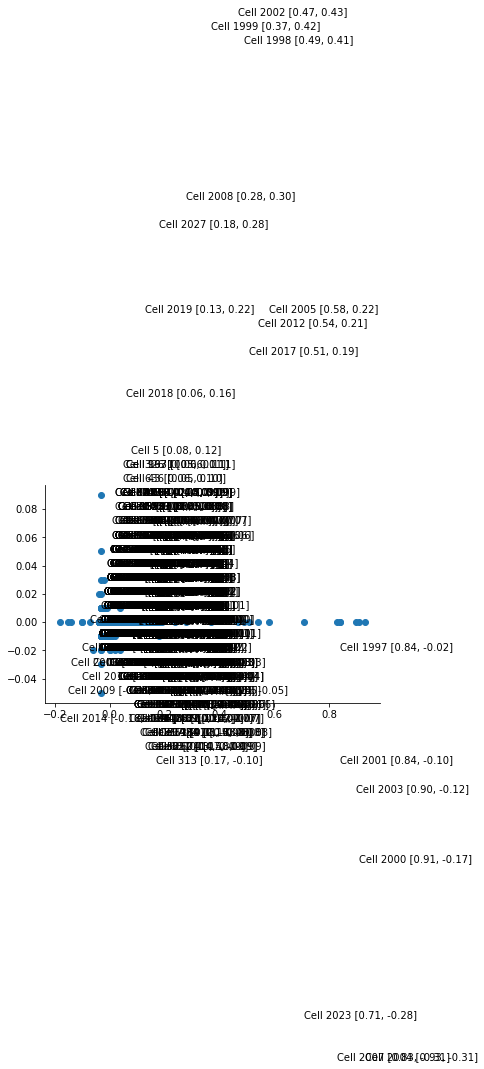

In [314]:
plt.scatter(pca[:, 0], pca[:, 30])
for i in range(len(pca)):
    title = f"Gene {i+1}" if i<4 else f"Cell {i-3}"
    title += f" [{pca[i, 0]:.2f}, {pca[i, 1]:.2f}]"
    print(title)
    plt.text(pca[i, 0], pca[i, 1], title)
sns.despine()

In [315]:
print(pca[i, 8])

0.0


In [316]:
pca

array([[ 0.02,  0.05, -0.02, ..., -0.  ,  0.  , -0.  ],
       [ 0.09, -0.05, -0.01, ...,  0.01,  0.  , -0.  ],
       [-0.03, -0.01, -0.02, ..., -0.01, -0.  ,  0.  ],
       ...,
       [ 0.  ,  0.02, -0.  , ...,  0.  , -0.  , -0.  ],
       [-0.  , -0.02,  0.01, ...,  0.  ,  0.  , -0.  ],
       [ 0.18,  0.28, -0.01, ...,  0.  ,  0.  , -0.  ]], dtype=float32)

In [317]:
len(pca)

2031

In [318]:
graph.ndata["label"]

tensor([-1., -1., -1.,  ..., nan, nan, nan])

In [319]:
graph

Graph(num_nodes=2031, num_edges=63898,
      ndata_schemes={'id': Scheme(shape=(1,), dtype=torch.int32), 'features': Scheme(shape=(31,), dtype=torch.float32), 'order': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})

In [320]:
from dgl.data.utils import save_graphs
dgl.save_graphs('graph-covid-std.bin', graph, labels=None)

In [321]:
w=graph.edata["weight"]

In [364]:
len(w)

63898

In [322]:
n=graph.ndata["features"].numpy().round(2)
n

array([[ 0.02,  0.05, -0.02, ..., -0.  ,  0.  , -0.  ],
       [ 0.09, -0.05, -0.01, ...,  0.01,  0.  , -0.  ],
       [-0.03, -0.01, -0.02, ..., -0.01, -0.  ,  0.  ],
       ...,
       [ 0.  ,  0.02, -0.  , ...,  0.  , -0.  , -0.  ],
       [-0.  , -0.02,  0.01, ...,  0.  ,  0.  , -0.  ],
       [ 0.18,  0.28, -0.01, ...,  0.  ,  0.  , -0.  ]], dtype=float32)

In [328]:
graph.ndata["label"]

tensor([-1., -1., -1.,  ..., nan, nan, nan])

In [329]:
graph.ndata["id"]

tensor([[ 0],
        [ 1],
        [ 2],
        ...,
        [-1],
        [-1],
        [-1]], dtype=torch.int32)

In [292]:
torch.save(w, 'weights-std.pt')

In [327]:
b.to_csv('nodes-data-features-std.csv')

In [326]:
len(b)

1

In [392]:
from dgl.data.utils import load_graphs
graph, label_dict = load_graphs("graph-covid-average.bin")

In [393]:
graph

[Graph(num_nodes=2031, num_edges=63898,
       ndata_schemes={'id': Scheme(shape=(1,), dtype=torch.int32), 'features': Scheme(shape=(31,), dtype=torch.float32), 'order': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.float32)}
       edata_schemes={'weight': Scheme(shape=(1,), dtype=torch.float32)})]

In [296]:
label_dict

{}